## Comparing between gradient boosting and InfiniteBoost for ranking problem

Experiments are run on the yahoo-letor, set 1 (details in Chapelle, O., & Chang, Y., 2011, January. Yahoo! learning to rank challenge overview. In Yahoo! Learning to Rank Challenge, pp. 1-24). Already prepared training and test files are used.

The fixed capacity value is used in these experiments because the loss function is not convex in this case and the adaptation on the holdout significantly underestimates capacity.

In [1]:
DATASET_FOLDER = './datasets/ltrc_yahoo/'
N_THREADS = 4

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import OrderedDict
import numpy
import joblib
import pandas

from infiniteboost import ResearchGradientBoostingBase, InfiniteBoosting
from infiniteboost.researchlosses import LambdaLossNDCG as LambdaLoss, NDCG_metric

## Preparing datasets: binning and saving mini-version of yahoo_letor

In [3]:
import os
if not os.path.isfile(DATASET_FOLDER + '_binned.pkl'):
    # preparing mini-version
    from sklearn.datasets import load_svmlight_file

    trainX, trainY, train_qid = load_svmlight_file(DATASET_FOLDER + 'set1.train.txt', query_id='qid')
    testX,  testY,  test_qid  = load_svmlight_file(DATASET_FOLDER + 'set1.test.txt',  query_id='qid')

    bin_trainX = numpy.zeros(trainX.shape, dtype='uint8', order='F')
    bin_testX  = numpy.zeros(testX.shape, dtype='uint8', order='F')

    _max_bins = 64
    for column in range(trainX.shape[1]):
        _train_column = trainX[:, column].toarray().flatten()
        _test_column  = testX[:, column].toarray().flatten()

        if len(numpy.unique(_train_column)) < _max_bins:
            _precs = numpy.unique(_train_column)[:-1]
        else:
            targets = numpy.linspace(0, 100, _max_bins + 1)[1:-1]
            _precs = numpy.percentile(_train_column, targets) 
        bin_trainX[:, column] = numpy.searchsorted(_precs, _train_column)
        bin_testX[:, column]  = numpy.searchsorted(_precs, _test_column)
        
    joblib.dump([bin_trainX, bin_testX, trainY, testY, train_qid, test_qid], 
                DATASET_FOLDER + '_binned.pkl', 
                protocol=2) 

In [4]:
bin_trainX, bin_testX, trainY, testY, train_qid, test_qid = joblib.load(DATASET_FOLDER + '_binned.pkl')

## Training 

Define parameters for boosting (the same parameters are used for InfiniteBoost and gradient boosting)

In [5]:
# define random parameters 
rank_params = dict(loss=LambdaLoss(train_qid, n_threads=N_THREADS), 
                   max_depth=7, max_features=0.7, subsample=0.7, 
                   n_estimators=3000, 
                   random_state=42, n_threads=N_THREADS)

In [6]:
rank_models = OrderedDict()

Train gradient boosting with different learning rates

In [7]:
for learning_rate in [0.05, 0.1, 0.2]:
    rank_gb = ResearchGradientBoostingBase(learning_rate=learning_rate, **rank_params)
    %time rank_gb.fit(bin_trainX, trainY)
    rank_models['shrinkage = ' + str(learning_rate)] = rank_gb
    joblib.dump(rank_models, './models/yahoo_lr_comparison.pkl', protocol=2)

CPU times: user 4h 24min 10s, sys: 11.4 s, total: 4h 24min 22s
Wall time: 1h 19min 35s
CPU times: user 4h 23min, sys: 8.67 s, total: 4h 23min 8s
Wall time: 1h 16min 57s
CPU times: user 4h 22min 21s, sys: 8.06 s, total: 4h 22min 29s
Wall time: 1h 16min 44s


Train InfiniteBoost with differnet fixed capacities

In [8]:
for capacity in [50., 100.]:
    inf_gb = InfiniteBoosting(capacity=capacity, **rank_params)
    %time inf_gb.fit(bin_trainX, trainY)
    rank_models['capacity = ' + str(capacity)] = inf_gb
    joblib.dump(rank_models, './models/yahoo_lr_comparison.pkl', protocol=2)

CPU times: user 4h 17min 59s, sys: 16.9 s, total: 4h 18min 16s
Wall time: 1h 16min 1s
CPU times: user 4h 19min 36s, sys: 10.2 s, total: 4h 19min 46s
Wall time: 1h 16min 21s


## Plotting

In [9]:
rank_models = joblib.load('./models/yahoo_lr_comparison.pkl')

In [10]:
# compute nDCG_p metric for different models and different p-values
from collections import defaultdict
def compute_qualities(models, X, y, qid, step=20):
    qualities = defaultdict(lambda :OrderedDict())
    metrics = OrderedDict()
    for _at in [100000, 10, 5, 3, 1]:
        metrics[_at] = NDCG_metric(qid, relevances=y, maximal=_at)
        
    for name, clf in list(models.items()):
        for i, p in enumerate(clf.staged_decision_function(X)):
            if (i + 1) % step != 0:
                continue
            for _at, metric in metrics.items():
                qualities[_at, name][i] = metric.compute(p)
                
    # reordering for easier plotting:
    Qualities = OrderedDict()
    for _at in metrics:
        Qualities[_at]  = OrderedDict()
        for name in models:
            Qualities[_at][name] = [list(qualities[_at, name].keys()), list(qualities[_at, name].values())]
    return Qualities

Qualities = compute_qualities(rank_models, bin_testX, testY, test_qid)
joblib.dump(Qualities, './plots/ndcg_qualities.pkl', protocol=2)

['./plots/ndcg_qualities.pkl']

In [11]:
joblib.dump(compute_qualities(rank_models, bin_trainX, trainY, train_qid), 
            './plots/ndcg_qualities_train.pkl', protocol=2)

['./plots/ndcg_qualities_train.pkl']

In [12]:
Qualities = joblib.load('./plots/ndcg_qualities.pkl')

Compare InfiniteBoost and gradient boosting for different nDCG_p measures

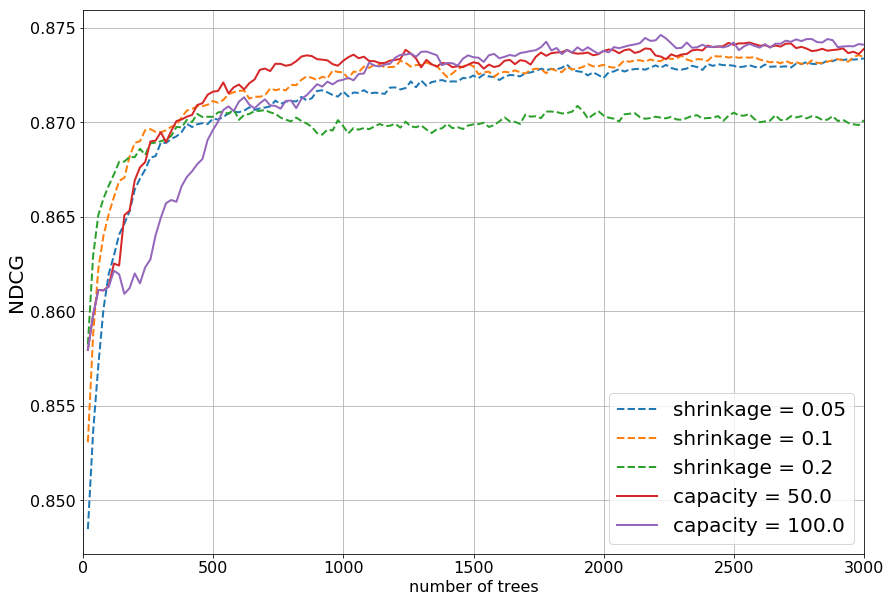

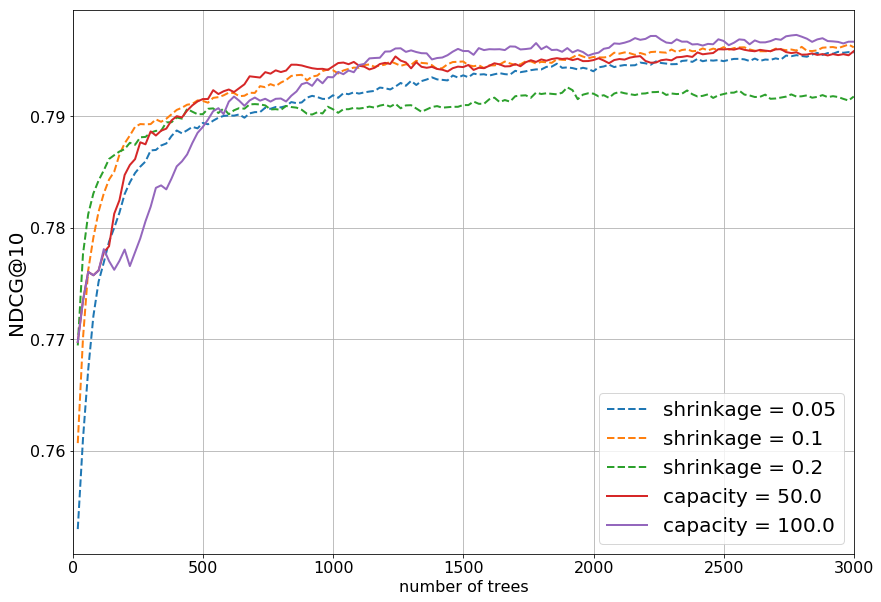

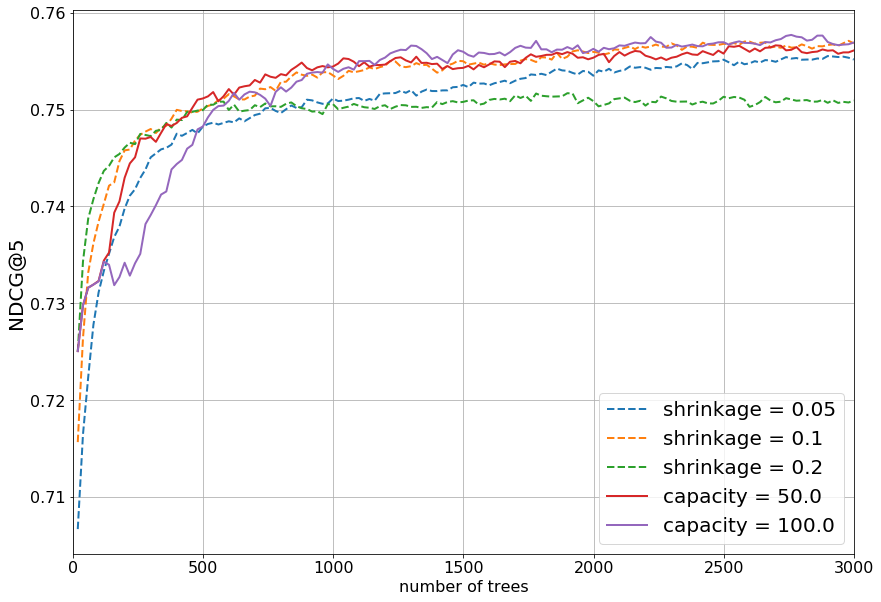

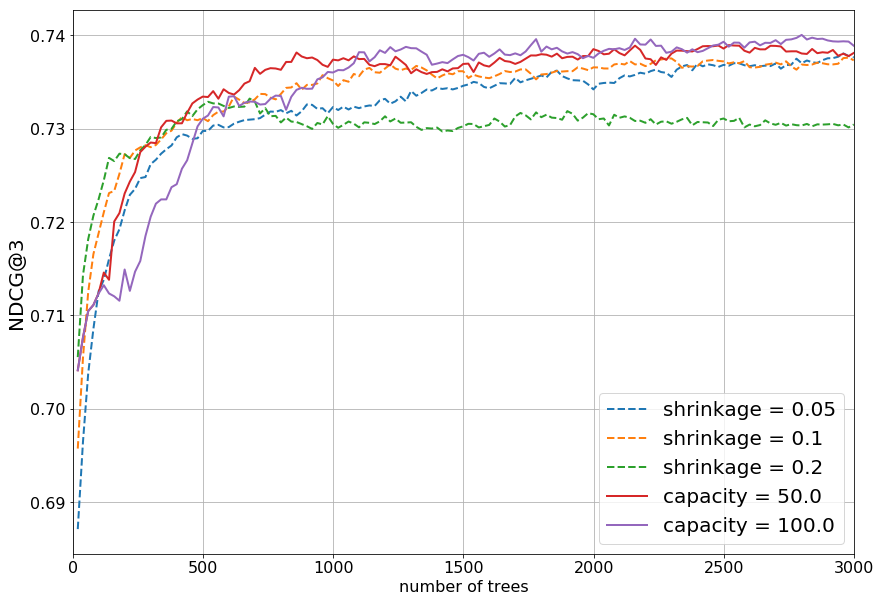

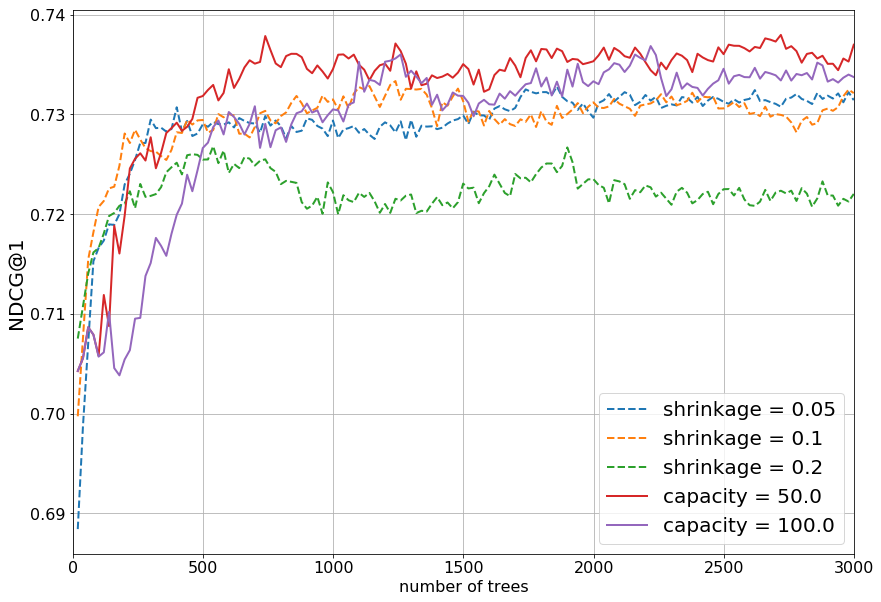

In [13]:
for _at, model_qualities in Qualities.items():
    plt.figure(figsize=[14, 10])
    for name, (stops, quals) in model_qualities.items():
        if name.startswith('shrinkage'):
            plt.plot(stops, quals, "--", label=name, linewidth=2)            
        else:
            plt.plot(stops, quals, label=name, linewidth=2)            
        
    plt.grid()
    plt.xlabel('number of trees', fontsize=16)
    plt.ylabel(('NDCG@' + str(_at)) if _at < 20 else 'NDCG', fontsize=20)
    plt.rcParams['xtick.labelsize'] = 16 
    plt.rcParams['ytick.labelsize'] = 16 
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['pdf.use14corefonts'] = True

    plt.legend(loc='lower right', fontsize=20)
    plt.xlim(0, 3000)

    plt.savefig('./plots/ndcg_at_{}.pdf'.format(_at), bbox_inches='tight')
    plt.show()

Compare InfiniteBoost and gradient boosting behaviour for different nDCG_p measures on the training samples

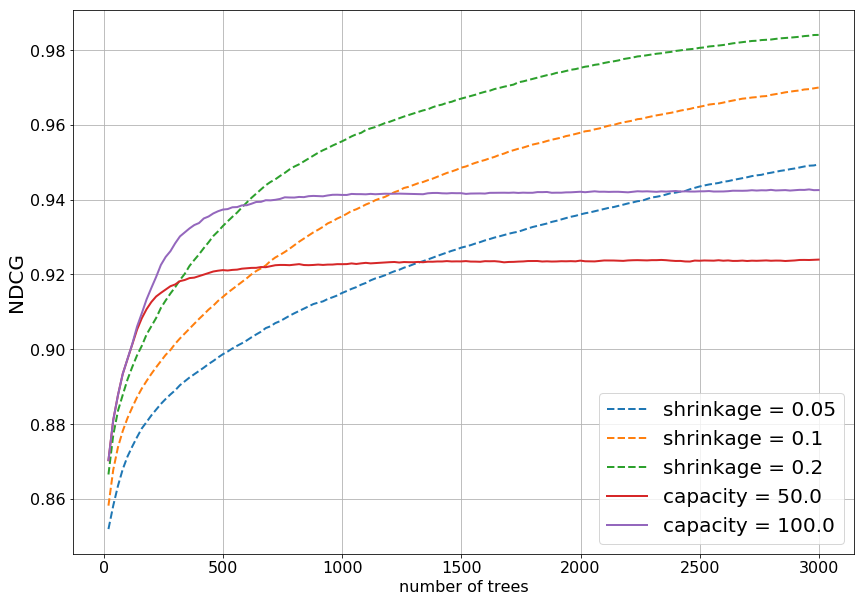

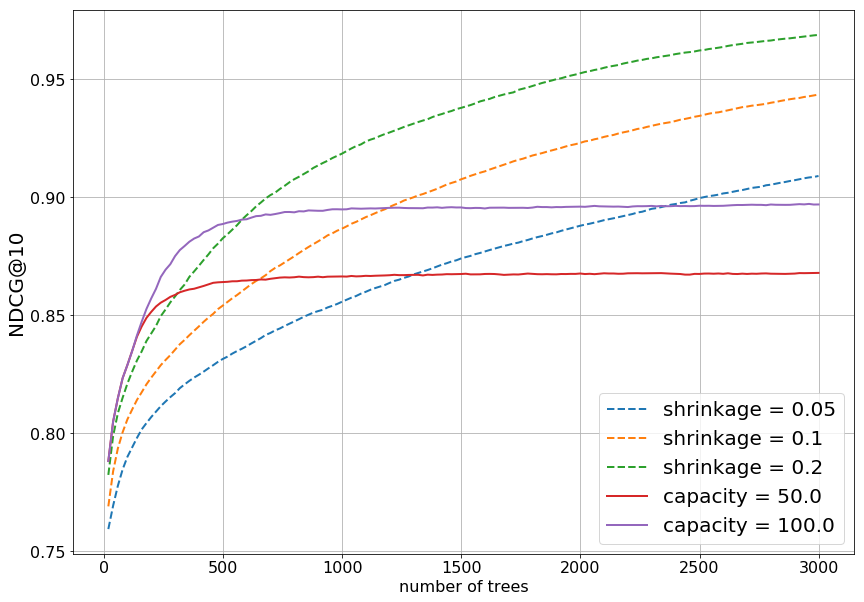

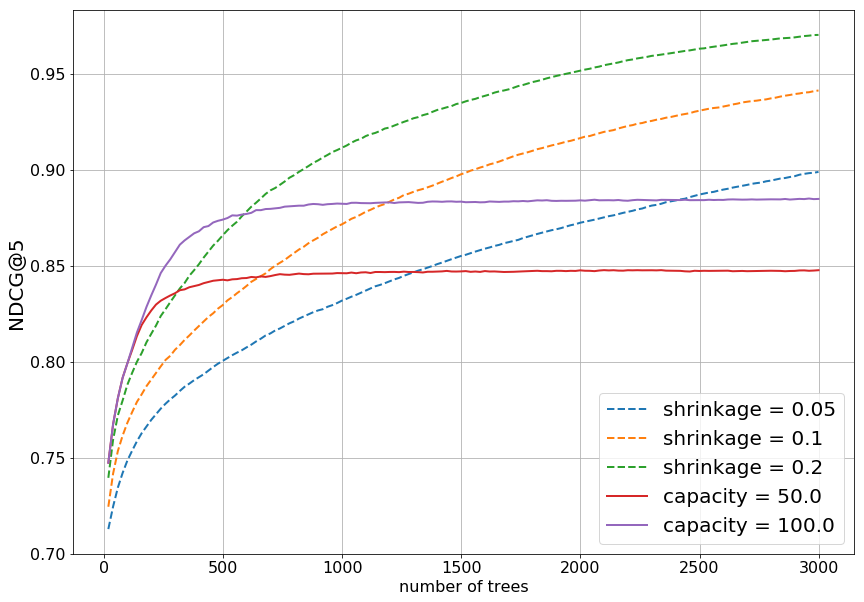

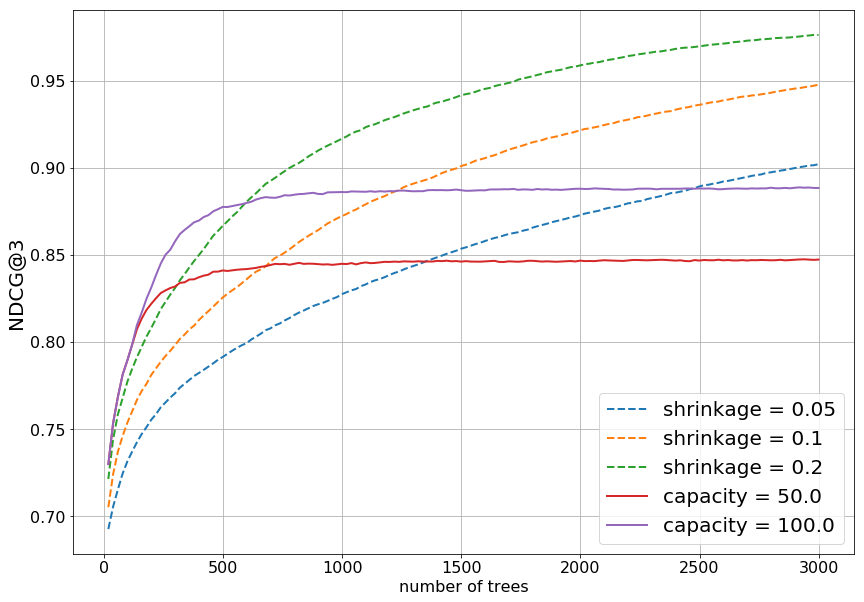

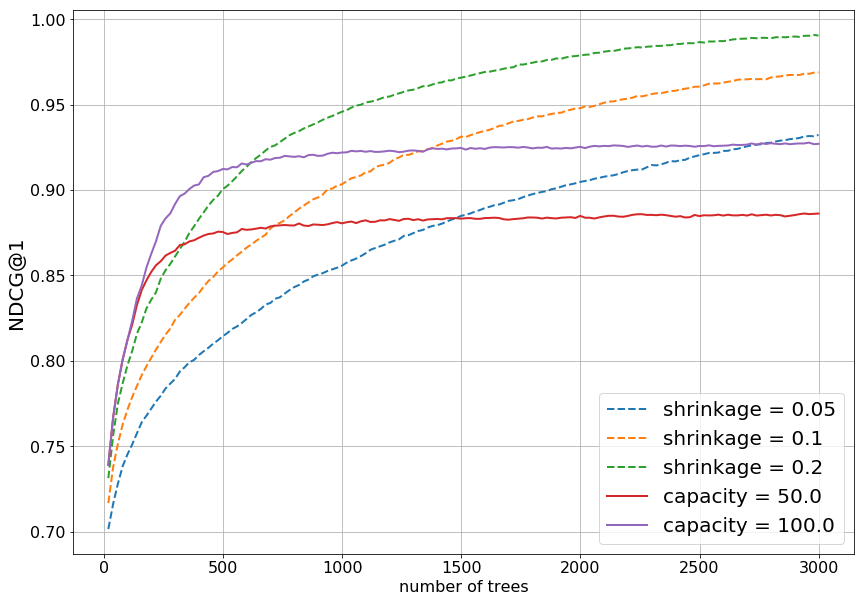

In [14]:
for _at, model_qualities in joblib.load('./plots/ndcg_qualities_train.pkl').items():
    plt.figure(figsize=[14, 10])
    for name, (stops, quals) in list(model_qualities.items()):
        if name.startswith('shrinkage'):
            plt.plot(stops, quals, "--", label=name, linewidth=2)            
        else:
            plt.plot(stops, quals, label=name, linewidth=2)            
        
    plt.grid()
    plt.xlabel('number of trees', fontsize=16)
    plt.ylabel(('NDCG@' + str(_at)) if _at < 20 else 'NDCG', fontsize=20)
    plt.rcParams['xtick.labelsize'] = 16 
    plt.rcParams['ytick.labelsize'] = 16 
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['pdf.use14corefonts'] = True

    plt.legend(loc='lower right', fontsize=20)

    plt.savefig('./plots/ndcg_at_{}_train.pdf'.format(_at), bbox_inches='tight')
    plt.show()